# Measure intensity vs. time in angular or concentric regions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import skimage.io

import matplotlib
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

import microfilm.splitmasks
from microfilm.dataset import MultipageTIFF

## Define paths to image and roi

In [2]:
image_path = '../microfilm/dataset/tests/test_folders/test_multipage_good/'
roi_path = '../microfilm/dataset/tests/test_folders/test_multipage_good/roi.bmp'

## Import data

Here we use a ```MultipageTIFF``` dataset as defined in the ```from microfilm.dataset``` module. We can however exchange this for a tif series, h5 or Nikon ND2 file.

In [3]:
image = MultipageTIFF(image_path)
roi = skimage.io.imread(roi_path)

## create roi
#import skimage.morphology
#roi = np.zeros(image.dims, dtype=np.uint8)
#roi[70,90] = 1
#roi = 255*skimage.morphology.binary_dilation(roi, skimage.morphology.disk(10)).astype(np.uint8)
#skimage.io.imsave('../tests/test_folders/test_multipage_good/roi.bmp', roi)

In [4]:
image.channel_name

['C2-MAX_mitosis.tif', 'C1-MAX_mitosis.tif']

## Measure the roi center of mass

In [5]:
cm = microfilm.splitmasks.get_roi_cm(roi_im=roi)

In [6]:
im_np = image.load_frame(channel_name=image.channel_name[0], frame=10)

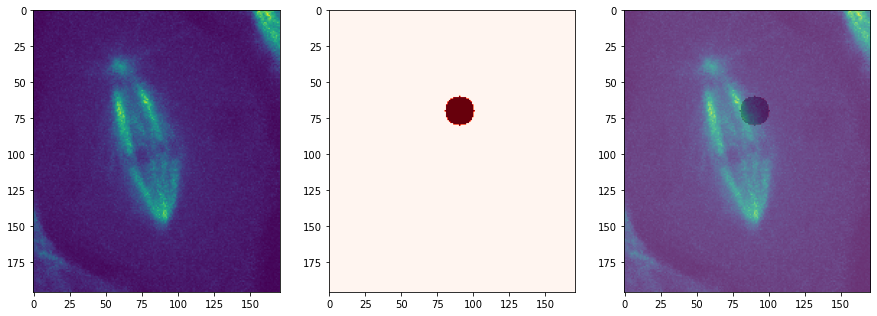

In [7]:
fig, ax = plt.subplots(1,3, figsize=(15,15))
ax[0].imshow(im_np)
ax[1].imshow(roi, cmap='Reds', vmin=0, vmax=250)
ax[2].imshow(im_np)
ax[2].imshow(roi, alpha = 0.2, cmap='Reds', vmin=0, vmax=200);

## Radial sectors

Here we create a labelled image with sectors as concentric rings. We can define the width and the number of rings.

We also create a colormap which optimally scales for the number of regions generated. The color map can be used both to display the labelled image and for regular plots (see below).

In [8]:
sector_width = 5
num_sectors = 10

In [9]:
radius_labels = microfilm.splitmasks.create_concentric_mask(center=cm, im_dims=image.dims,
                                                         sector_width=sector_width, num_sectors=num_sectors)
colors_rad, cmap_rad = microfilm.splitmasks.get_cmap_labels(radius_labels, cmap_name='cool')

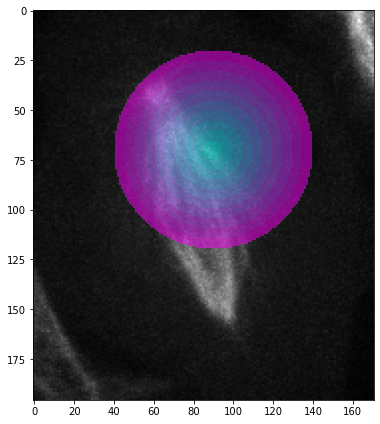

In [10]:
myplot = microfilm.splitmasks.plot_sectors(image, radius_labels, cmap=cmap_rad);

To save the figure, just use:

In [11]:
myplot.savefig('mysectors.png')

## Angular sectors

Here we create a labelled image with sectors as "pie" parts of a disk. We can define the angular size of the parts and the radius of the disk. Again, we create an optimal color map.

In [12]:
angular_width = 20
max_rad =50
sector_labels = microfilm.splitmasks.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad)
colors_angle, cmap_angle = microfilm.splitmasks.get_cmap_labels(sector_labels, cmap_name='viridis')

To display the image and the sectors, you can use the ```plot_sectors``` function:

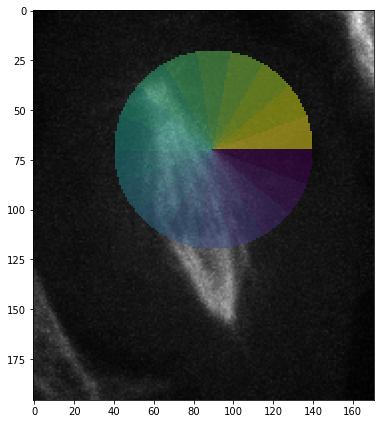

In [13]:
microfilm.splitmasks.plot_sectors(image, sector_labels, cmap=cmap_angle);

## Angular and radial sectors

We can also combine the radial and angular masks, to create only a ring with a given width. For that we use again the ```create_sector_mask``` function but use **and additional parameter ```radius``` for the ring width**.

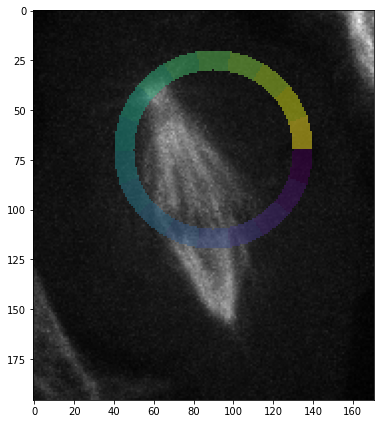

In [15]:
angular_width = 20
max_rad = 50
radius = 10
sector_labels = microfilm.splitmasks.create_sector_mask(center=cm, im_dims=image.dims,
                                                     angular_width=angular_width, max_rad=max_rad, radius=radius)
colors_angle, cmap_angle = microfilm.splitmasks.get_cmap_labels(sector_labels, cmap_name='viridis')

microfilm.splitmasks.plot_sectors(image, sector_labels, cmap=cmap_angle);

## Extracting signals

With the labelled image of sectors and the time-lapse data, we can now extract the intensity in each sector across time and plot it. If multiple channels are available in the dataset, we can change it.

In [16]:
channel = image.channel_name[0]

signal_radius = microfilm.splitmasks.measure_intensities(time_image=image.frame_generator(channel=channel), 
                                                      im_labels=radius_labels,max_time=300)
signal_angle = microfilm.splitmasks.measure_intensities(time_image=image.frame_generator(channel=channel), 
                                                     im_labels=sector_labels,max_time=300)


To plot the signals you can use the ```plot_signals``` function. You can pass the colormap array produced by the ```get_cmap_labels``` function to color the curves with the same colors as the corresponding sectors.


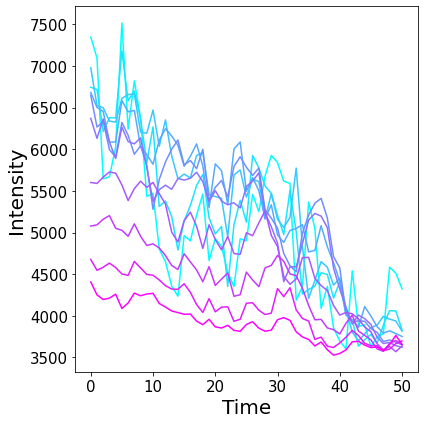

In [17]:
myplot = microfilm.splitmasks.plot_signals(signal_radius, color_array=colors_rad);

## Plotting

The plotting functions return simple Matplotlib axes, so one can combine them into more complex plots:

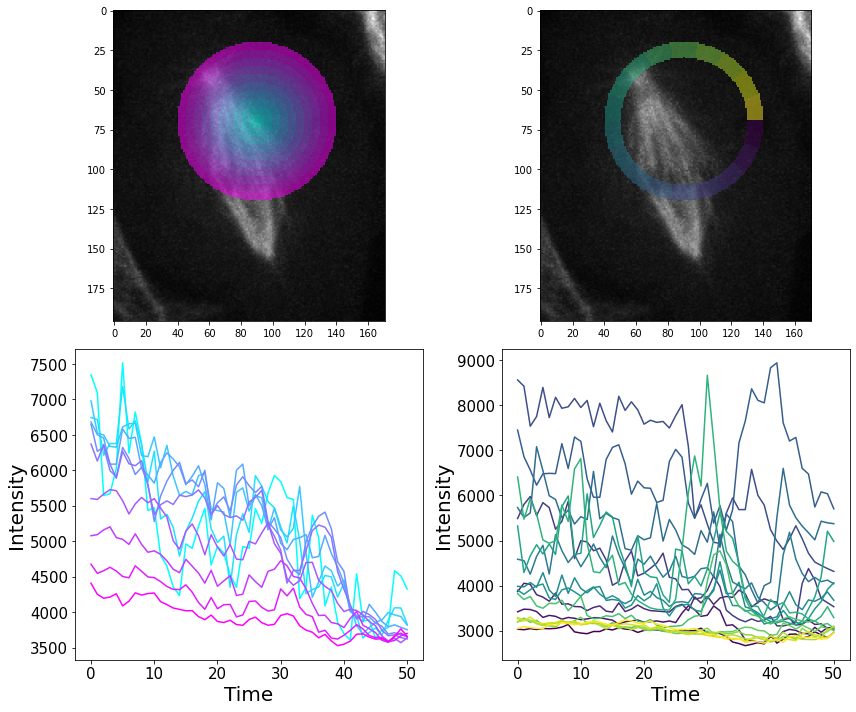

In [18]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

microfilm.splitmasks.plot_signals(signal_radius, color_array=colors_rad, ax=ax[1,0]);
microfilm.splitmasks.plot_signals(signal_angle, color_array=colors_angle, ax=ax[1,1]);

microfilm.splitmasks.plot_sectors(image, radius_labels, cmap=cmap_rad, ax=ax[0,0]);
microfilm.splitmasks.plot_sectors(image, sector_labels, cmap=cmap_angle, ax=ax[0,1]);
plt.tight_layout()

## Export

To save a simple plot you can use the Matplotlib ```savefig``` function with all its options. This works both for the image plots and the signal plots:

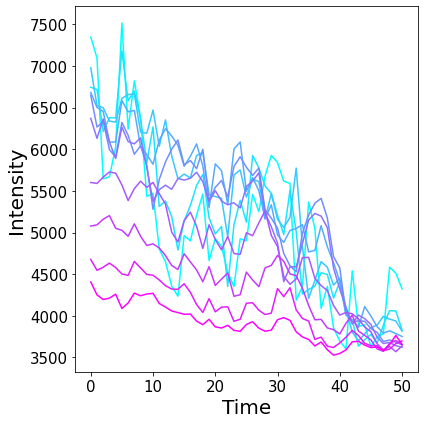

In [19]:
myplot = microfilm.splitmasks.plot_signals(signal_radius, color_array=colors_rad);

myplot.savefig('myplot.png')

To export the data as CSV file use the ```save_signal``` function. You can export in two different format, 'long' or 'wide'. In long format you obtain a table with three columns - time, sector, intensity - while in 'wide' format the rows correspond to time and the columns to sectors.

In [20]:
microfilm.splitmasks.save_signal(signal=signal_radius, name='signal_radius_long.csv', format='long')

microfilm.splitmasks.save_signal(signal=signal_radius, name='signal_radius_wide.csv', format='wide')

To re-import the data you can just use the standard Pandas reader:

In [21]:
import pandas as pd
pd.read_csv('signal_radius_long.csv')

,time,sector,intensity
0,0,0,7348.579710
1,1,0,7095.826087
2,2,0,5644.507246
3,3,0,5671.275362
4,4,0,6026.623188
...,...,...,...
505,46,9,3624.617209
506,47,9,3583.294715
507,48,9,3653.734417
508,49,9,3763.945799


## Interactive display

In [22]:
import ipywidgets as ipw

In [23]:
%matplotlib widget

In [24]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0] = microfilm.splitmasks.plot_sectors(image, sector_labels, cmap=cmap_angle, ax=ax[0])
ax[1] = microfilm.splitmasks.plot_signals(signal_angle, color_array=colors_angle, ax=ax[1])  
time_line = ax[1].plot([0,0],[signal_angle.min(), signal_angle.max()],'-r')
plt.tight_layout()

def plot_sectors_time(t):
    ax[0].get_images()[0].set_data(image.load_frame(image.channel_name[0],t)) 
    #im.set_array(image.load_frame(image.channel_name[0],t))
    time_line[0].set_xdata([t,t])
    
ipw.interactive(plot_sectors_time, t=ipw.IntSlider(value=0, min=0, max=image.max_time-1))

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

interactive(children=(IntSlider(value=0, description='t', max=50), Output()), _dom_classes=('widget-interact',…